In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx

%matplotlib inline

In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
sys.path.append('/home/bharris/biccn_paper/scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')


In [14]:
from rank import rank
from egad import run_egad
from egad_by_gene import run_egad_gene_score

import biccn_nw_perf_funcs as perf
import load_pearson_networks

In [12]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [30]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

## Load Data

In [11]:
dataset_dict = perf.dataset_dict
genes = perf.genes

In [66]:
markers = pd.read_csv('/home/bharris/biccn_paper/data/stephan_marker_nw.csv',
                      index_col=0)
markers.drop(['GABAergic', 'Glutamatergic', 'Non.Neuronal','L6.IT.Car3'],
             axis=1,
             inplace=True)
fix_subclass = np.vectorize(lambda x: x.replace('.', '_'))
markers.columns = fix_subclass(markers.columns)

markers.rename(columns={
    'L5_6_NP': 'L5.6_NP',
    'L2_3_IT': 'L2.3_IT'
},
               inplace=True)
subclasses = markers.columns

In [51]:
nws_path = '/home/bharris/biccn_paper/data/networks/aggregate/coexpression_nw_subclass_label_'

## Subclass Specific Co-expression

In [52]:
is_marker = pd.DataFrame(markers.astype(bool).any(axis=1).astype(float))

In [53]:
vip_genes = genes[markers['Vip'].astype(bool)]

In [67]:
subclass_perf = []
subclass_by_gene_perf = []
vip_nws = {}
for subclass in subclasses:
    logging.info(subclass)
    if subclass=='L5_6_NP':
        subclass = 'L5.6_NP'
    nw = pd.read_hdf(f'{nws_path}{subclass}_unranked.hdf5', 'nw')
    rank(nw.values)
    perf = run_egad(markers, nw)['AUC']
    perf.name = subclass
    subclass_perf.append(perf)

    res = run_egad_gene_score(is_marker, nw)[0]
    res.name = subclass
    subclass_by_gene_perf.append(res)
    vip_nws[subclass] = nw.loc[vip_genes, vip_genes]
    del nw
    gc.collect()

2020-08-27 12:28:33,906 - L5_IT
2020-08-27 12:28:42,615 - Vip
2020-08-27 12:28:51,397 - L5.6_NP
2020-08-27 12:29:00,106 - L6_IT
2020-08-27 12:29:08,610 - L2.3_IT
2020-08-27 12:29:17,583 - L6b
2020-08-27 12:29:28,015 - L6_CT
2020-08-27 12:29:37,022 - Sncg
2020-08-27 12:29:45,903 - Sst
2020-08-27 12:29:54,610 - Lamp5
2020-08-27 12:30:03,142 - Pvalb
2020-08-27 12:30:11,510 - L5_ET


In [72]:
subclass_order = np.sort(subclasses)

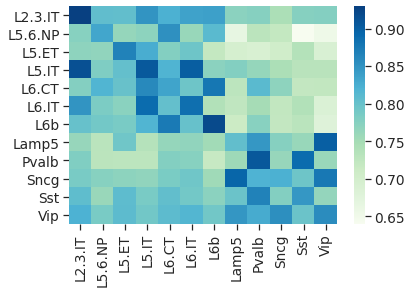

In [117]:
ax=sns.heatmap(pd.concat(subclass_perf,
                      axis=1).loc[subclass_order, subclass_order],
            cmap='GnBu')
labels_func = np.vectorize(lambda x: x.replace('_', '.'))
ax.set_xticklabels(labels_func(subclass_order))
ax.set_yticklabels(labels_func(subclass_order))
plt.show()

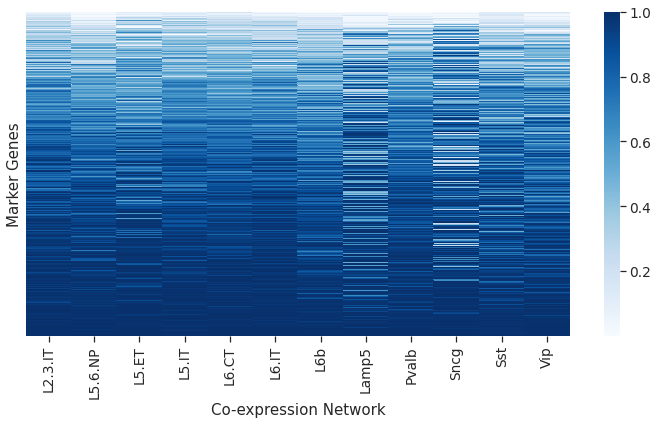

In [121]:
by_gene = pd.concat(subclass_by_gene_perf, axis=1)

by_gene.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    by_gene.loc[by_gene.mean(axis=1).sort_values().index, subclass_order],
    cmap='Blues',
    yticklabels=False,
    ax=ax)
ax.set(ylabel='Marker Genes', xlabel='Co-expression Network')
labels_func = np.vectorize(lambda x: x.replace('_', '.'))
ax.set_xticklabels(labels_func(subclass_order))
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/supp6B.pdf', transparent=True)